# Feature Selection Tutorial

## 1. Introduction to Feature Selection

Feature selection is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. Feature selection techniques are used for three reasons:

* simplification of models to make them easier to interpret by researchers/users,
* shorter training times,
* enhanced generalization by reducing overfitting

The central premise when using a feature selection technique is that the data contains many features that are either redundant or irrelevant, and can thus be removed without incurring much loss of information.

There are three main categories of feature selection algorithms: wrappers, filters and embedded methods. [1] This tutorial will mainly focuses on one of the well-known embedded methods Lasso and its variants.


## 2. Introduction to Lasso

### 2.1 What's Lasso
Embedded methods are a catch-all group of techniques which perform feature selection as part of the model construction process. Lasso is one of them for constructing a linear model. It penalizes the regression coefficients with an L1 penalty, shrinking many of them to zero. Any features which have non-zero regression coefficients are 'selected' by the Lasso algorithm. So it performs both variable selection and regularization.

The loss function of a linear model with L1 penalty will has the following form:

$\frac{1}{2} \sum_{n=1}^{N}\{t_n - w^T\phi(x_n)\}^2 + \frac{\lambda}{2} \sum_{j=1}^{M} |w_j|$

The first part is the original square loss $\frac{1}{2} \sum_{n=1}^{N}\{t_n - w^T\phi(x_n)\}^2$. The second part is the L1 penalty $\frac{\lambda}{2} \sum_{j=1}^{M} |w_j|$, in which M is the total number of features, $w$ is the weight vectore and $\lambda$ controls how much L1 penalty the contributes to the overall loss. L1 penalty can helps to improve the generalization of the model because it model the model complexity by $\sum_{j=1}^{M} |w_j|$

### 2.2 Why Lasso Can be Used for Feature Selection
An important characteristic of the L1 penalty is that it will leads to sparse models. Sparse models means the weight of unimportant/irrelevent features will shrink to 0. 

### 2.3 An Example

In [170]:
import matplotlib
import matplotlib.pyplot as plt 

import numpy as np

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LinearRegression, lasso_path, lasso_stability_path, lars_path

import warnings


from scipy import linalg

from sklearn.linear_model import (RandomizedLasso, lasso_stability_path,
                                  LassoLarsCV)
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, precision_recall_curve
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.utils.extmath import pinvh
from sklearn.exceptions import ConvergenceWarning

%matplotlib inline

In [231]:
def mutual_incoherence(X_relevant, X_irelevant):
    """Mutual incoherence, as defined by formula (26a) of [Wainwright2006].
    """
    projector = np.dot(np.dot(X_irelevant.T, X_relevant),
                       pinvh(np.dot(X_relevant.T, X_relevant)))
    return np.max(np.abs(projector).sum(axis=1))


def plot_sel_path(X, y, coef, method='Lasso'):
    """Plot feature selection result
    """
    if method == 'Lasso':
        alpha_grid, _, scores_path = lars_path(X, y, method='lasso', eps=0.05)
    elif method == 'Stability':
        alpha_grid, scores_path = lasso_stability_path(X, y, eps=0.05)
        
    plt.figure()
    hg = plt.plot(alpha_grid[1:] ** .333, scores_path[coef != 0].T[1:], 'r')
    hb = plt.plot(alpha_grid[1:] ** .333, scores_path[coef == 0].T[1:], 'k')
    ymin, ymax = plt.ylim()
    plt.xlabel(r'$(\alpha / \alpha_{max})^{1/3}$')
    plt.ylabel('Stability score: proportion of times selected')
    mi = mutual_incoherence(X[:, coef != 0],
                            X[:, coef == 0])
    plt.title('Stability Scores Path - Mutual incoherence: %.1f' % mi)
    plt.axis('tight')
    plt.legend((hg[0], hb[0]), ('relevant features', 'irrelevant features'),
               loc='best')   
    
def plot_sel_auc(X, y, coef, methods=['Lasso', 'Stability']):
    """Plot feature selection auc
    """
    models = {}
    for m in methods:
        if m == 'Lasso':
            sel_m = LassoLarsCV(cv=6).fit(X, y)
            score = np.abs(sel_m.coef_)
        elif m == 'Stability':
            sel_m = RandomizedLasso().fit(X, y)
            score = sel_m.scores_
        models[m] = score

#     plt.figure()
    fig, ax = plt.subplots()
    for name in models:
        score = models[name]
        n_rel = np.sum(coef != 0)
        precision, recall, thresholds = precision_recall_curve(coef != 0, score)
        print n_rel, recall
        
        ax.plot(n_rel/recall, recall, 
                 label="%s. AUC: %.3f" % (name, auc(recall, precision)))
       
    plt.show()   
    
def gen_simulation_dataset(n_features=500, n_relevant_features=3, 
                           noise_level=0.2, coef_min=0.2, n_samples=10000,
                          rng=np.random.RandomState(0), conditioning=1):

    block_size = n_relevant_features

    # The coefficients of our model
    coef = np.zeros(n_features)
    coef[:n_relevant_features] = coef_min + rng.rand(n_relevant_features)

    # The correlation of our design: variables correlated by blocs of 3
    corr = np.zeros((n_features, n_features))
    for i in range(0, n_features, block_size):
        corr[i:i + block_size, i:i + block_size] = 1 - conditioning
    corr.flat[::n_features + 1] = 1
    corr = linalg.cholesky(corr)

    # Our design
    X = rng.normal(size=(n_samples, n_features))
    X = np.dot(X, corr)
    # Keep [Wainwright2006] (26c) constant
    X[:n_relevant_features] /= np.abs(
        linalg.svdvals(X[:n_relevant_features])).max()
    X = StandardScaler().fit_transform(X.copy())

    # The output variable
    y = np.dot(X, coef)
    y /= np.std(y)
    # We scale the added noise as a function of the average correlation
    # between the design and the output variable
    y += noise_level * rng.normal(size=n_samples)
    mi = mutual_incoherence(X[:, :n_relevant_features],
                            X[:, n_relevant_features:])    
    
    return X, y, coef, mi

In [213]:
rng = np.random.RandomState(0)

In [219]:
# Exp 1
n_samples = 10000
n_features = 3
noise_level = 0.2

X = rng.rand(n_samples, n_features)
coef = np.zeros(n_features)
coef[0] = 0.0
coef[1] = 1.0
coef[2] = 2.0

y = np.dot(X, coef) + noise_level * rng.normal(size=n_samples)

print X.shape, y.shape

lr = LinearRegression()
lr.fit(X, y)
print 'coefficient of linear regression\n%s' % str(lr.coef_)

lr = Lasso(alpha=0.001)
lr.fit(X, y)
print 'coefficient of lasso\n%s' % str(lr.coef_)

coefficient of linear regression
[-0.00457423  1.01218244  1.99865625]
coefficient of lasso
[-0.          1.00003744  1.98665356]


(10000, 4) (10000,)
coefficient of linear regression
[  3.33868622e+12  -3.33868622e+12   1.00427751e+00   2.09641421e-03]
coefficient of lasso
[  1.99162443e+00   3.64257014e-16   9.92358639e-01   0.00000000e+00]


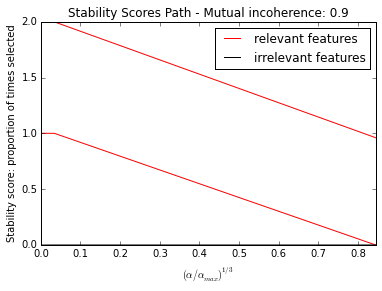

In [229]:
# Exp 2
n_samples = 10000
n_features = 4
n_relevant_features = 3
noise_level = 0.2

X = rng.rand(n_samples, n_features)
X[:,1] = X[:,0]
coef = np.zeros(n_features)
coef[:n_relevant_features] = np.ones(n_relevant_features)

y = np.dot(X, coef) + noise_level * rng.normal(size=n_samples)

print X.shape, y.shape

lr = LinearRegression()
lr.fit(X, y)
print 'coefficient of linear regression\n%s' % str(lr.coef_)

lr = Lasso(alpha=0.001)
lr.fit(X, y)
print 'coefficient of lasso\n%s' % str(lr.coef_)

plot_sel_path(X, y, coef)

### 2.4 Drawbacks of Lasso

There are some well-known limitations of L1 penalized models, including
1. Lasso will tend to select an individual variable out of a group of highly correlated features,
2. even when the correlation between features is not too high, the conditions under which L1-penalized methods consistently select “good” features can be restrictive in general.


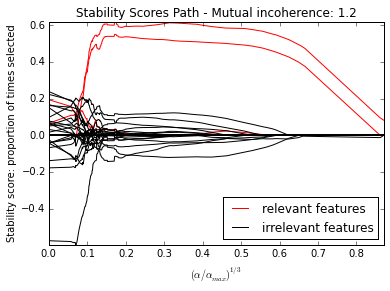

In [238]:
# Exp 3 small mutual incoherence
X, y, coef, mi = gen_simulation_dataset(n_samples=25, rng=rng, conditioning=1)

plot_sel_path(X, y, coef, 'Lasso')

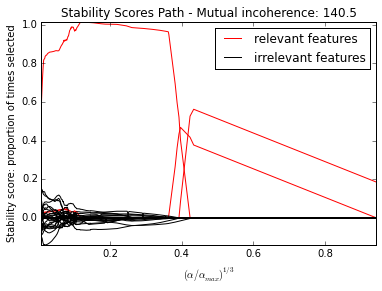

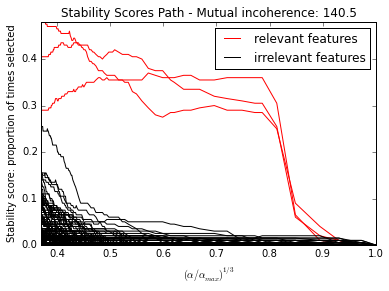

In [237]:
# Exp 4 large mutual incoherence
X, y, coef, mi = gen_simulation_dataset(n_samples=25, rng=rng, conditioning=1e-4)

plot_sel_path(X, y, coef, 'Lasso')

plot_sel_path(X, y, coef, 'Stability')


In [ ]:
# Exp 5 real dataset


## 3. Variants of Lasso

Improvements to the LASSO include Bolasso which bootstraps samples, and FeaLect which scores all the features based on combinatorial analysis of regression coefficients.

## 4. References
1. Guyon, Isabelle, and André Elisseeff. "An introduction to variable and feature selection." Journal of machine learning research 3.Mar (2003): 1157-1182. [link](http://www.jmlr.org/papers/volume3/guyon03a/guyon03a.pdf)
* Feature selection - Wikipedia. [link](https://en.wikipedia.org/wiki/Feature_selection)

* Sklearn [link](http://scikit-learn.org/stable/modules/feature_selection.html#randomized-l1)
* F. Bach, Model-Consistent Sparse Estimation through the Bootstrap. [link]( https://hal.inria.fr/hal-00354771/)
* N. Meinshausen, P. Buhlmann, Stability selection, Journal of the Royal Statistical Society, 72 (2010)[link](http://arxiv.org/pdf/0809.2932.pdf)
* http://stats.stackexchange.com/questions/45643/why-l1-norm-for-sparse-models
* UCI Machine Learning Repository [link](http://archive.ics.uci.edu/ml/index.html)
* http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/
* http://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_recovery.html#sphx-glr-auto-examples-linear-model-plot-sparse-recovery-py
* http://statistics.berkeley.edu/sites/default/files/tech-reports/709.pdf
* Covariance, covariance is a measure of how much two random variables change together https://en.wikipedia.org/wiki/Covariance

## Experiment Design
### Lasso
* Dataset: synthetic examples, UCL ML dataset (regression, classification)
    * y = x_0 + 0.5 x_1 + 0 * x_2 + noise
    * y = x_0 + x_0 + noise
* Regression path (different lambda/alpha)
    * How will the weight/coefficient (same scale?) for each feature change with the lambda/alpha, @M2009 figure 1,4,7
* Performance:
    * How many features remain (relevent/irrelevent)
    * Task performance


### Bolasso & Bolasso-S


5 [ 1.   0.8  0. ]
5 [ 1.   0.8  0.6  0.4  0.2  0. ]


/Users/jinyi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in divide


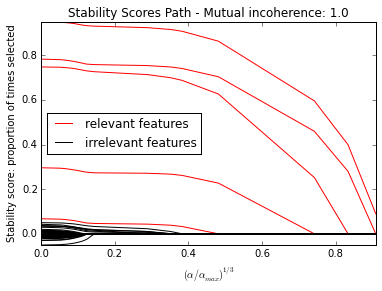

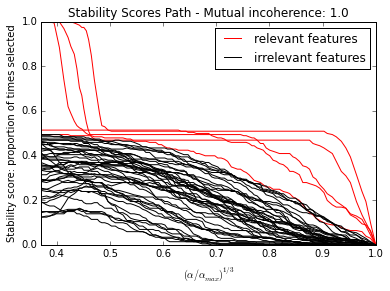

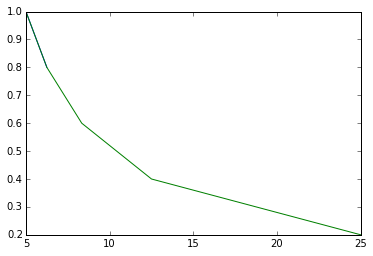

In [212]:
n_sample = 1000
n_feature = 50
n_relevant_feature = 5
noise_level = 0.2

rng = np.random.RandomState(0)

X = rng.rand(n_sample, n_feature)
coef = np.zeros(n_feature)
coef[:n_relevant_feature] = rng.rand(n_relevant_feature)
y = np.dot(X, coef)
y += noise_level * rng.normal(size=n_sample)

plot_sel_path(X, y, coef, "Lasso")

plot_sel_path(X, y, coef, "Stability")

plot_sel_auc(X, y, coef)